<table style="float:left; border:none">
   <tr style="border:none">
       <td style="border:none">  
           <img 
               src="../images/EmpleaFidelidad.png" 
               style="width:200px"
           >
           </a>    
       </td>
   </tr>
</table>
<div style="float:right;font-size: 20px;"><h2>IBM - 08 - Decission Tree Classifier</h2></div>

<a id="top"></a> <br>
## Índice
1. [Carga de paquetes y datos](#1)<br>
    1.1. [Librerías y clases](#11)<br>
    1.2. [Lectura de datos](#12)<br>
    1.3. [Filtrado de variable target](#13)<br>
2. [Modelo](#2)<br>
    2.1. [Separación en train y test](#21)<br>
    2.2. [Target encoding](#22)<br>
    2.3. [Métrica para optimización de hiperparámetros](#23)<br>
    2.4. [Preprocesamiento](#24)<br>
    2.5. [Pipe modelo](#25)<br>
    2.6. [Optimización de hiperparámetros con Optuna](#26)<br>
    2.7. [Visualización de hiperparámetros](#27)<br>
    2.8. [Entrenamiento del modelo con mejores hiperparámetros](#28)<br>
3. [Evaluación del modelo](#3)<br>
    3.1. [Métricas principales](#31)<br>
    3.2. [Reporte de clasificación](#32)<br>
    3.3. [Matriz de confusión](#33)<br>
    3.4. [ROC curve](#34)<br>
    3.5. [Precission-Recall Curve](#35)<br>
    3.6. [Feature importance](#36)<br>
4. [Exportación con Shelve](#4)<br>
    4.1. [Exportación con Shelve](#41)<br>

***
<a id="1"></a> <br>
## 1. Carga de paquetes y datos

<a id="11"></a>
### 1.1. Librerías y clases

In [58]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib. pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import *
from sklearn import preprocessing
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder, StandardScaler,  FunctionTransformer, LabelEncoder, binarize
from sklearn.pipeline import make_pipeline, make_union
from sklearn.tree import DecisionTreeClassifier,plot_tree
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import GridSearchCV, StratifiedKFold, cross_val_score
from sklearn import tree
from sklearn.naive_bayes import GaussianNB
from imblearn.pipeline import Pipeline 
from sklearn.inspection import permutation_importance
import shelve
import plotly.io as pio
from imblearn.over_sampling import SMOTE
pio.renderers.default = 'iframe'
from IPython.display import Image
import pydotplus
import optuna

import warnings
warnings.filterwarnings("ignore")

In [59]:
# Esta clase permite dropear columnas de un DataFrame dentro de un pipeline

class ColumnDropper(BaseEstimator, TransformerMixin):
    def __init__(self,columns):
        self.columns=columns

    def transform(self,X,y=None):
        return X.drop(self.columns,axis=1)

    def fit(self, X, y=None):
        return self  

<a id="12"></a>
### 1.2. Lecura de datos

In [60]:
# Carga de dataset
key= "ibm.clean.Education.csv"
path="../Data/"
df = pd.read_csv(path + key)
df.sample(3)

,EmployeeID,Age,Attrition,BusinessTravel,Department,DistanceFromHome,Education,EducationField,EnvironmentSatisfaction,Gender,...,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager,Employee Source,AgeStartedWorking
702,6369,32,0,Travel_Frequently,Research & Development,24,Master,Life Sciences,1,Female,...,0,20,1,3,19,6,11,8,Adzuna,12
1168,4327,29,0,Travel_Frequently,Research & Development,2,Below college,Life Sciences,2,Male,...,2,3,3,3,2,2,2,1,LinkedIn,26
2122,8965,19,1,Non-Travel,Research & Development,10,Bachelor,Medical,1,Female,...,0,1,2,4,1,1,0,0,Seek,18


<a id="13"></a>
### 1.3. Filtrado de variable target

**Se eliminan todas las instancias con valor de Attrition igual a "Terminated" ya que el modelo estima la probabilidad de que un empleado renuncie a la compañia**

In [61]:
#Elimino las instancias con valor "Termination" de la columna "Attrition"
df = df[df["Attrition"] != "Termination"]

***
<a id="2"></a> <br>
## 2. Modelo

<a id="21"></a>
### 2.1. Separación en train y test

In [62]:
# Separacion en train y test
# Selección de variable targuet
y = df.Attrition
# Selección de features
X = df.drop(["Attrition"], axis = 1)

# Separación en train y test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 161, stratify= y)

# Verificación de distribución de variable targuet en train y test
print("Distribución de variable target en Train \n", y_train.value_counts(normalize=True))
print("========================================")
print("Distribución de variable target en Test \n", y_test.value_counts(normalize=True))

Distribución de variable target en Train 
 0    0.842728
1    0.157272
Name: Attrition, dtype: float64
Distribución de variable target en Test 
 0    0.84279
1    0.15721
Name: Attrition, dtype: float64


<a id="22"></a>
### 2.2. Target Encoding

In [63]:
# Transformación de variable targuet categórica en numérica
le = preprocessing.LabelEncoder()
y_train = le.fit_transform(y_train)
y_test = le.transform(y_test)

<a id="23"></a>
### 2.3. Métrica para optimización de hiperparámetros

<table style="float:center; border:none">
   <tr style="border:none">
       <td style="border:none">  
           <img 
               src="../images/F2score.png" 
               style="width:500"
           >
           </a>    
       </td>
   </tr>
</table>

In [64]:
# Creacion de score f2 
ftwo_scorer = make_scorer(fbeta_score, beta=2)

<a id="24"></a>
### 2.4. Preprocesamiento

In [65]:
# Definimos las columnas segun su tipo

#Features categoricas ordinales
ordinal_categorical_features= ["BusinessTravel", "Education"]

BusinessTravel=["Non-Travel","Travel_Rarely","Travel_Frequently"]
Education= ["Below college","College","Bachelor","Master","Doctor"]

categories=[BusinessTravel,Education]

#Features categoricas nominales
nominal_categorical_features=["Department", "EducationField","Gender","JobRole","OverTime","Employee Source","MaritalStatus"]

#Features numericas
numeric_features= ["DistanceFromHome","MonthlyIncome"]

#Features de otro tipo (no se va a transformar de ninguna forma)
other_features=["Age","EnvironmentSatisfaction","JobInvolvement","JobLevel","JobSatisfaction","NumCompaniesWorked","PercentSalaryHike",
               "PerformanceRating","RelationshipSatisfaction","StockOptionLevel","TotalWorkingYears","TrainingTimesLastYear","WorkLifeBalance",
               "YearsAtCompany","YearsInCurrentRole","YearsSinceLastPromotion","YearsWithCurrManager","AgeStartedWorking"]


# Creamos los transformadores para cada tipo de dato
ordinal_transformer = OrdinalEncoder(categories = categories, handle_unknown =  "use_encoded_value", unknown_value= np.nan)
nominal_transformer = OneHotEncoder(handle_unknown='ignore')
numeric_transformer = StandardScaler()

# Creamos el preprocesador
preprocessor = ColumnTransformer([
        ('ord', ordinal_transformer, ordinal_categorical_features),
        ('nom', nominal_transformer, nominal_categorical_features),
        ('num', numeric_transformer, numeric_features),
        ('other', 'passthrough', other_features)  # No hacemos nada con 'other'
    ])

<a id="25"></a>
### 2.5. Pipe modelo

In [66]:
pipe = Pipeline([
    ("column_dropper", ColumnDropper(["EmployeeID"])),
    ("preprocessor", preprocessor),
         ("smote", SMOTE(random_state=42)),  # Oversampling con SMOTE
     ("dtree", DecisionTreeClassifier())
])

pipe

Pipeline(steps=[('column_dropper', ColumnDropper(columns=['EmployeeID'])),
                ('preprocessor',
                 ColumnTransformer(transformers=[('ord',
                                                  OrdinalEncoder(categories=[['Non-Travel',
                                                                              'Travel_Rarely',
                                                                              'Travel_Frequently'],
                                                                             ['Below '
                                                                              'college',
                                                                              'College',
                                                                              'Bachelor',
                                                                              'Master',
                                                                              'Doctor']],
                                                                 handle_unknown='use_encoded_value',
                                                                 unknown_value=nan),
                                                  ['BusinessTravel',
                                                   'Education'])...
                                                   'NumCompaniesWorked',
                                                   'PercentSalaryHike',
                                                   'PerformanceRating',
                                                   'RelationshipSatisfaction',
                                                   'StockOptionLevel',
                                                   'TotalWorkingYears',
                                                   'TrainingTimesLastYear',
                                                   'WorkLifeBalance',
                                                   'YearsAtCompany',
                                                   'YearsInCurrentRole',
                                                   'YearsSinceLastPromotion',
                                                   'YearsWithCurrManager',
                                                   'AgeStartedWorking'])])),
                ('smote', SMOTE(random_state=42)),
                ('dtree', DecisionTreeClassifier())])

<a id="26"></a>
### 2.6. Optimización de hiperparámetros con Optuna

In [67]:
# Función objetivo de optuna

def objective_pipe(trial):
    
    #===============================================================================================================#
    #HIPERPARAMETROS DEL PIPE
    max_depth_dtree = trial.suggest_int("max_depth_dtree", 2, 30) # dtree
    min_samples_leaf_dtree = trial.suggest_int("min_samples_leaf_dtree", 2, 200) # dtree
    
    
    # Pipeline modelo
    pipe = Pipeline([
         ("column_dropper", ColumnDropper(["EmployeeID"])),
        ("preprocessor", preprocessor),
             ("smote", SMOTE(random_state=42)),  # Oversampling con SMOTE
         ("dtree", DecisionTreeClassifier(max_depth = max_depth_dtree, min_samples_leaf = min_samples_leaf_dtree))])
   
    # Cross validation
    kfold=StratifiedKFold(n_splits=3, random_state=1,shuffle=True)    
    
    # Return
    return cross_val_score(pipe, X_train, y_train, cv=kfold, scoring=ftwo_scorer).mean()

In [68]:
%%time
models=[]
scores=[]
pipe_study = optuna.create_study(direction='maximize')
pipe_study.optimize(objective_pipe, n_trials=10)
model='dtree'
score=pipe_study.best_trial.value
models.append(model)
scores.append(score)

[I 2024-06-09 19:42:19,975] A new study created in memory with name: no-name-fef4e135-377a-4c7d-9209-29f39d6f6c63
[I 2024-06-09 19:42:20,392] Trial 0 finished with value: 0.26847069711153426 and parameters: {'max_depth_dtree': 26, 'min_samples_leaf_dtree': 59}. Best is trial 0 with value: 0.26847069711153426.
[I 2024-06-09 19:42:20,696] Trial 1 finished with value: 0.29317114111363507 and parameters: {'max_depth_dtree': 18, 'min_samples_leaf_dtree': 120}. Best is trial 1 with value: 0.29317114111363507.
[I 2024-06-09 19:42:21,027] Trial 2 finished with value: 0.2763382341241086 and parameters: {'max_depth_dtree': 9, 'min_samples_leaf_dtree': 78}. Best is trial 1 with value: 0.29317114111363507.
[I 2024-06-09 19:42:21,364] Trial 3 finished with value: 0.26847069711153426 and parameters: {'max_depth_dtree': 15, 'min_samples_leaf_dtree': 60}. Best is trial 1 with value: 0.29317114111363507.
[I 2024-06-09 19:42:21,701] Trial 4 finished with value: 0.24094606652870798 and parameters: {'max_

CPU times: total: 9.53 s
Wall time: 3.34 s


In [69]:
print('Number of finished trials:', len(pipe_study.trials))
print('Best trial: score {}, params {}'.format(pipe_study.best_trial.value, pipe_study.best_trial.params))

Number of finished trials: 10
Best trial: score 0.3109449839385185, params {'max_depth_dtree': 4, 'min_samples_leaf_dtree': 193}


<a id="27"></a>
### 2.7. Visualización de hiperparámetros

In [70]:
optuna.visualization.plot_optimization_history(pipe_study)

In [71]:
optuna.visualization.plot_parallel_coordinate(pipe_study)

In [72]:
optuna.visualization.plot_slice(pipe_study)

In [73]:
optuna.visualization.plot_param_importances(pipe_study)

In [74]:
optuna.visualization.plot_edf(pipe_study)

In [75]:
optuna.visualization.plot_contour(pipe_study)

<a id="28"></a>
### 2.8.Entrenamiento del modelo con mejores hiperparámetros

In [76]:
#Mejores Hiperparámetros del estudio
pipe_study.best_trial.params

{'max_depth_dtree': 4, 'min_samples_leaf_dtree': 193}

In [77]:
# Seteado de mejores hiperparametros en el pipeline
best_params = {
               "dtree__min_samples_leaf" : pipe_study.best_trial.params['min_samples_leaf_dtree'],
               "dtree__max_depth" : pipe_study.best_trial.params['max_depth_dtree']
                }

pipe.set_params(**best_params)

Pipeline(steps=[('column_dropper', ColumnDropper(columns=['EmployeeID'])),
                ('preprocessor',
                 ColumnTransformer(transformers=[('ord',
                                                  OrdinalEncoder(categories=[['Non-Travel',
                                                                              'Travel_Rarely',
                                                                              'Travel_Frequently'],
                                                                             ['Below '
                                                                              'college',
                                                                              'College',
                                                                              'Bachelor',
                                                                              'Master',
                                                                              'Doctor']],
                                                                 handle_unknown='use_encoded_value',
                                                                 unknown_value=nan),
                                                  ['BusinessTravel',
                                                   'Education'])...
                                                   'PercentSalaryHike',
                                                   'PerformanceRating',
                                                   'RelationshipSatisfaction',
                                                   'StockOptionLevel',
                                                   'TotalWorkingYears',
                                                   'TrainingTimesLastYear',
                                                   'WorkLifeBalance',
                                                   'YearsAtCompany',
                                                   'YearsInCurrentRole',
                                                   'YearsSinceLastPromotion',
                                                   'YearsWithCurrManager',
                                                   'AgeStartedWorking'])])),
                ('smote', SMOTE(random_state=42)),
                ('dtree',
                 DecisionTreeClassifier(max_depth=4, min_samples_leaf=193))])

In [78]:
#Entrenamiento del modelo con los mejores hiperparámetros
model = pipe.fit(X_train, y_train)

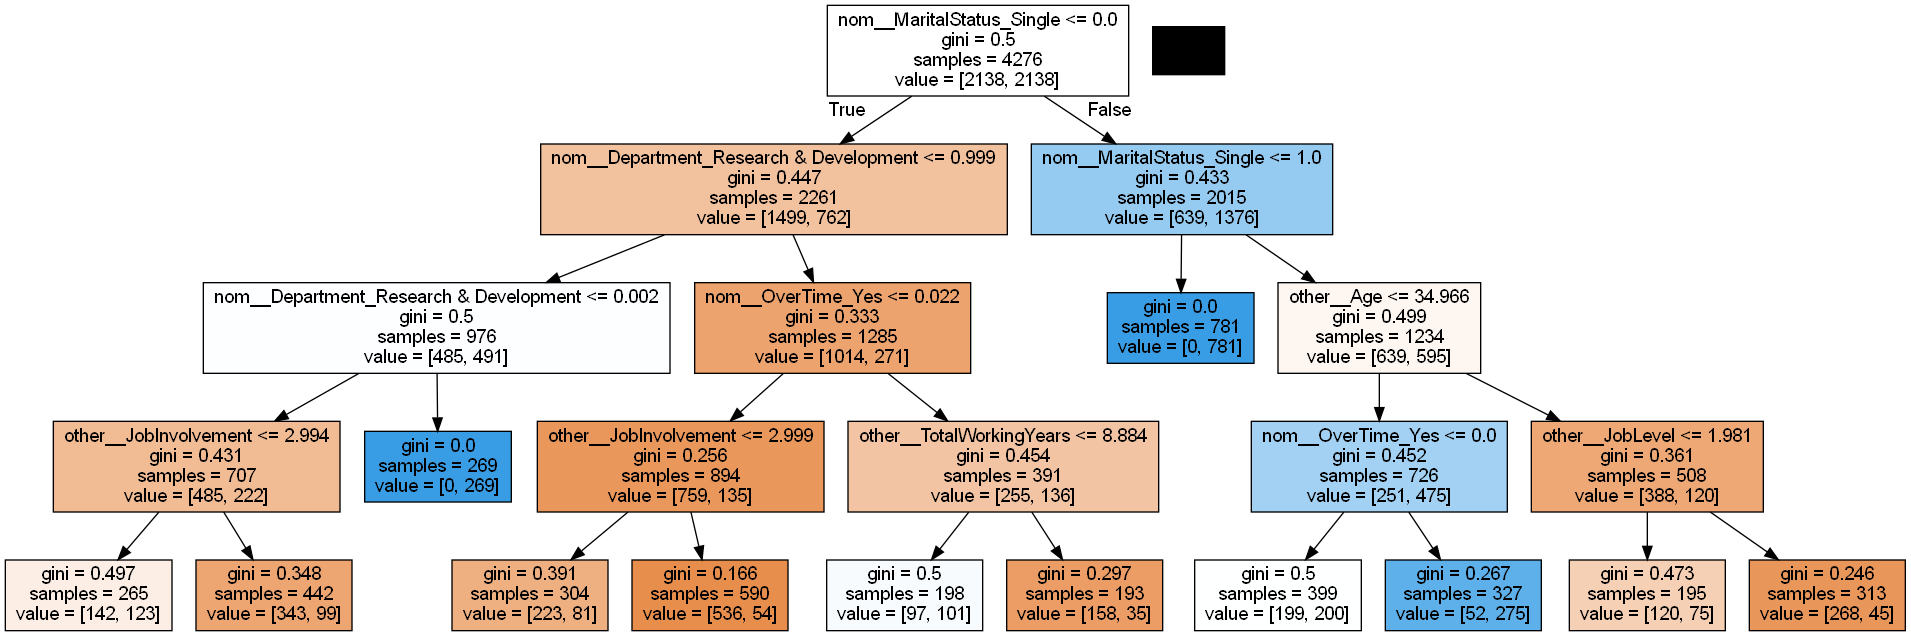

In [79]:
# Ploteado del modelo

pipe.fit(X_train,y_train)


features = pipe["preprocessor"].get_feature_names_out()


# Ploteo de arbol de decisión
dot_data = tree.export_graphviz(model["dtree"], out_file=None,feature_names= features, filled = True)
graph2 = pydotplus.graph_from_dot_data(dot_data)
Image(graph2.create_png())

***
<a id="3"></a> <br>
## 3. Evaluación del modelo

<a id="31"></a>
### 3.1. Métricas principales

In [80]:
#predicciones train y test
model_pred_train = model.predict(X_train)
model_pred_test= model.predict(X_test)
#==========================

ftwo_train = fbeta_score(y_train, model_pred_train, beta = 2)
ftwo_test = fbeta_score(y_test ,model_pred_test, beta = 2)

fone_train = f1_score(y_train, model_pred_train)
fone_test = f1_score(y_test, model_pred_test)

accuracy_train = accuracy_score(y_train, model_pred_train)
accuracy_test = accuracy_score(y_test, model_pred_test)

ROC_train = roc_auc_score(y_train, model_pred_train)
ROC_test = roc_auc_score(y_test, model_pred_test)

recall_train = recall_score(y_train, model_pred_train)
recall_test = recall_score(y_test, model_pred_test)

precision_train = precision_score(y_train, model_pred_train)
precision_test = precision_score(y_test, model_pred_test)

In [81]:
df_metricas = pd.DataFrame({'Models': ['Decission Tree Classifier'],
                       'F2 Score Train':  [ftwo_train],
                       'F2 Score Test': [ftwo_test],
                       'F1 Score Train':  [fone_train],
                       'F1 Score Test': [fone_test],                       
                       'Accuracy Score Train':  [accuracy_train],
                       'Accuracy Score Test': [accuracy_test],
                       'ROC AUC Score Train':  [ROC_train],
                       'ROC AUC Score Test': [ROC_test],
                       'Recall Score Train':  [recall_train],
                       'Recall Score Test': [recall_test],
                      "Precision Score Train" : [precision_train],
                      "Precision Score Test" : [precision_test]})
df_metricas

,Models,F2 Score Train,F2 Score Test,F1 Score Train,F1 Score Test,Accuracy Score Train,Accuracy Score Test,ROC AUC Score Train,ROC AUC Score Test,Recall Score Train,Recall Score Test,Precision Score Train,Precision Score Test
0,Decission Tree Classifier,0.391181,0.365169,0.361842,0.332268,0.770595,0.752955,0.625382,0.605727,0.413534,0.390977,0.321637,0.288889


<a id="32"></a>
### 3.2. Reporte de clasificación

In [82]:
print(classification_report(y_test,model_pred_test))

              precision    recall  f1-score   support

           0       0.88      0.82      0.85       713
           1       0.29      0.39      0.33       133

    accuracy                           0.75       846
   macro avg       0.58      0.61      0.59       846
weighted avg       0.79      0.75      0.77       846



<a id="33"></a> <br>
### 3.3. Matriz de confusión

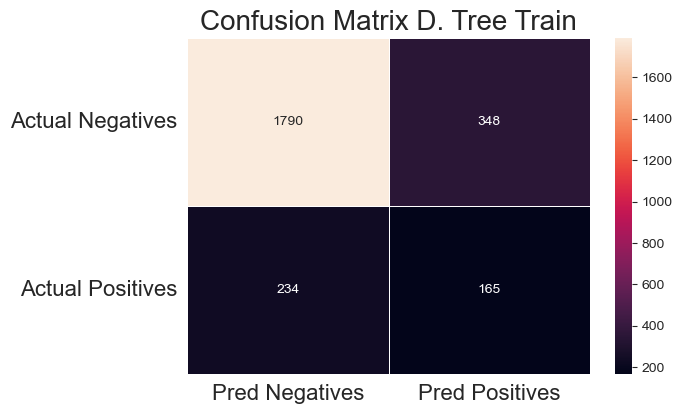

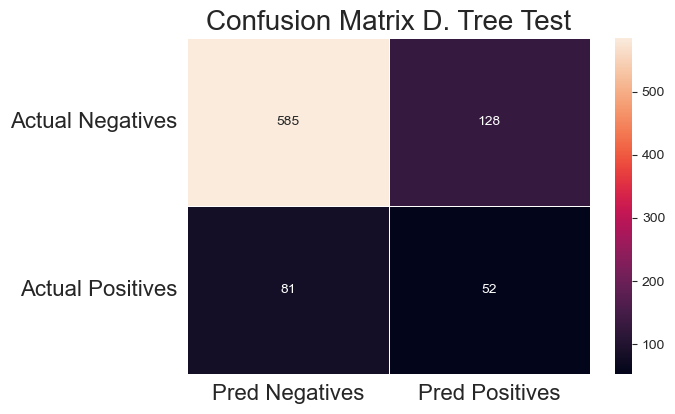

In [83]:
# Matriz de confusión para modelo seleccionado
conf_matrix = confusion_matrix(y_train, model_pred_train)
f, ax = plt.subplots(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt="d", linewidths=.6, ax=ax)
plt.title("Confusion Matrix D. Tree Train", fontsize=20)
plt.subplots_adjust(left=0.15, right=0.99, bottom=0.15, top=0.99)
ax.set_yticks(np.arange(conf_matrix.shape[0]) + 0.5, minor=False)
ax.set_xticklabels(['Pred Negatives', 'Pred Positives'],fontsize=16, rotation=360)
ax.set_yticklabels(['Actual Negatives', 'Actual Positives'], fontsize=16, rotation=360)
plt.show()

conf_matrix = confusion_matrix(y_test, model_pred_test)
f, ax = plt.subplots(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt="d", linewidths=.6, ax=ax)
plt.title("Confusion Matrix D. Tree Test", fontsize=20)
plt.subplots_adjust(left=0.15, right=0.99, bottom=0.15, top=0.99)
ax.set_yticks(np.arange(conf_matrix.shape[0]) + 0.5, minor=False)
ax.set_xticklabels(['Pred Negatives', 'Pred Positives'],fontsize=16, rotation=360)
ax.set_yticklabels(['Actual Negatives', 'Actual Positives'], fontsize=16, rotation=360)
plt.show()

<a id="34"></a> <br>
### 3.4. ROC Curve

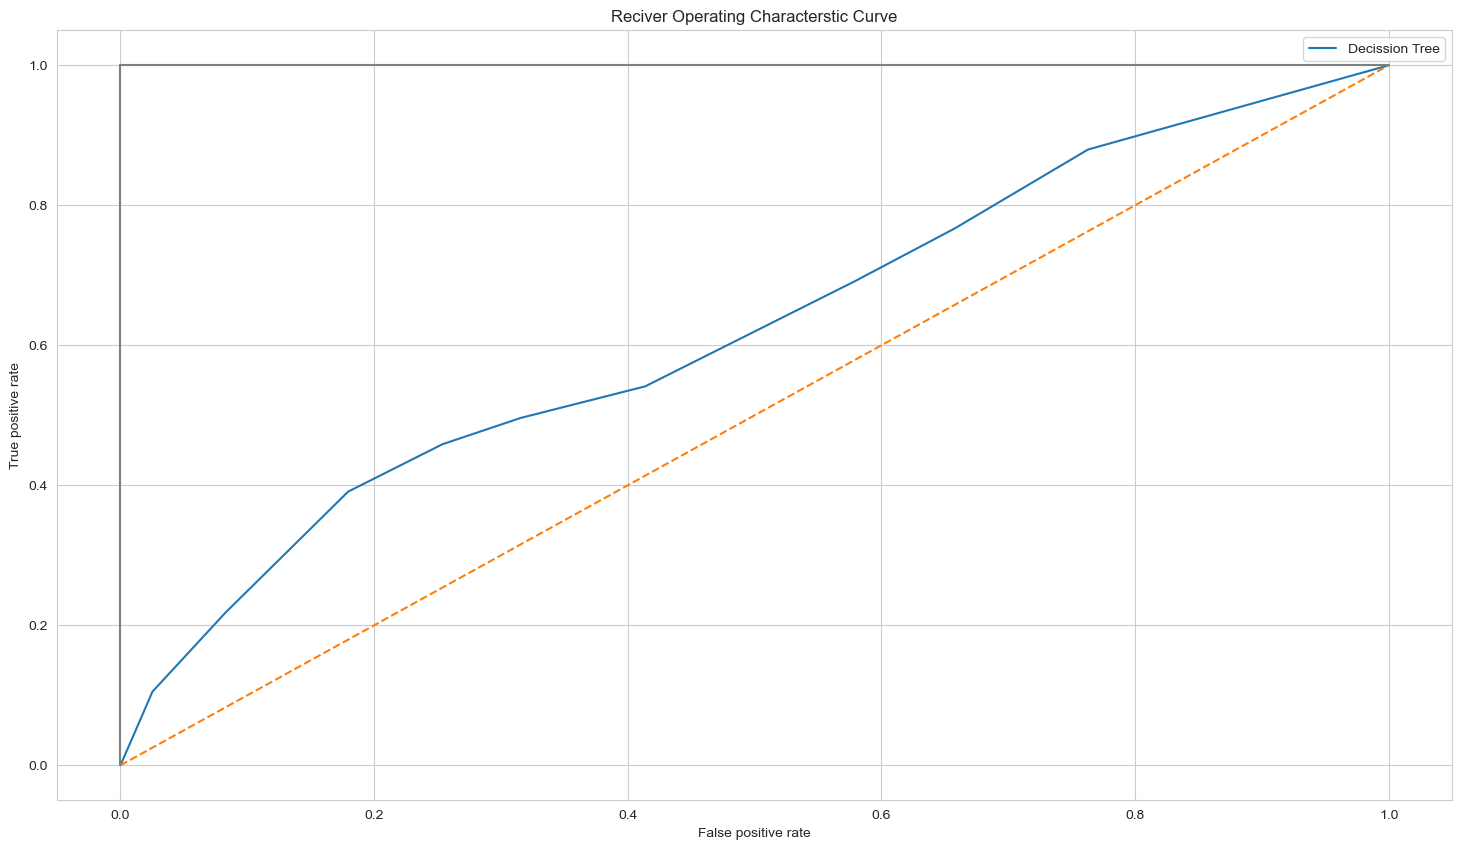

In [84]:
# Obtención de probabilidades de test
probsdmodel_dtree = model.predict_proba(X_test)
predsdmodel_dtree = probsdmodel_dtree[:,1]


# Generación de ROC curve
model_false_positive_rate , model_true_positive_rate , model_threshold = roc_curve(y_test , predsdmodel_dtree)



# Gráfico curva ROC
sns.set_style('whitegrid')
plt.figure(figsize=(18,10))
plt.title('Reciver Operating Characterstic Curve')

plt.plot(model_false_positive_rate , model_true_positive_rate,label="Decission Tree")


plt.plot([0,1],ls='--')
plt.plot([0,0],[1,0],c='.5')
plt.plot([1,1],c='.5')
plt.ylabel('True positive rate')
plt.xlabel('False positive rate')
plt.legend()
plt.show()

<a id="35"></a> <br>
### 3.5. Precission-Recall Curve

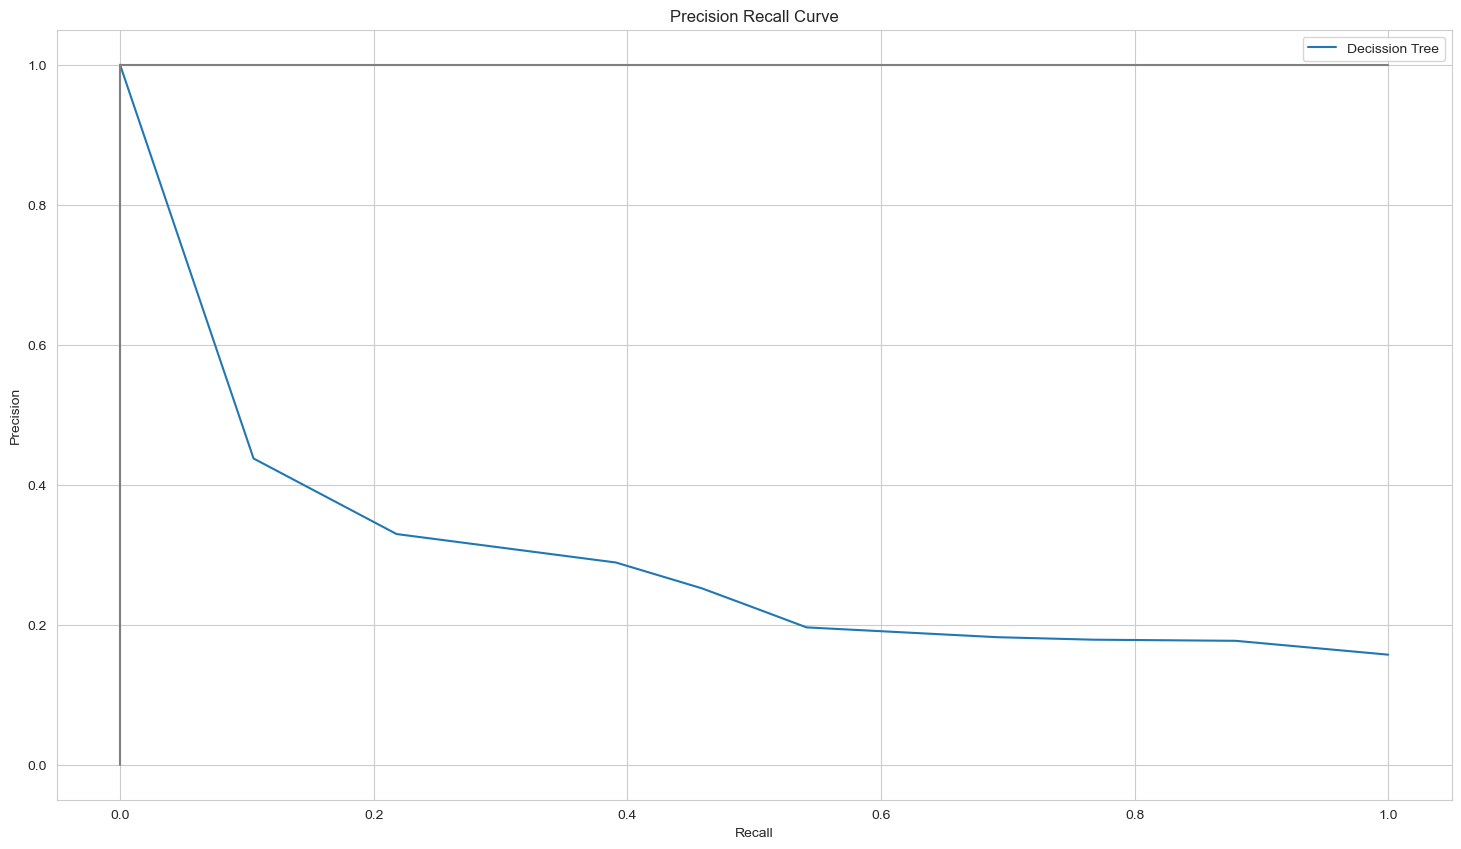

In [85]:
probsdmodel_dtree = model.predict_proba(X_test)
predsdmodel_dtree = probsdmodel_dtree[:,1]

# Generación métricas precision, recall 
dtree_precision , dtree_recall ,dtree_threshold = precision_recall_curve(y_test , predsdmodel_dtree)


# Gráfico curva precision recall curve
sns.set_style('whitegrid')
plt.figure(figsize=(18,10))
plt.title('Precision Recall Curve')

plt.plot(dtree_recall , dtree_precision,label="Decission Tree")


plt.plot([0,0],[1,0],c='.5')
plt.plot([1,1],c='.5')
plt.ylabel('Precision')
plt.xlabel('Recall')
plt.legend()
plt.show()

<a id="36"></a> <br>
### 3.6. Feature importance 

In [86]:
# Se busca la feature importance con permutation importance
feature_importance = permutation_importance(model, X_test, y_test, n_repeats=5, random_state=0)

In [87]:
# Se crea un dataframe de features importances
importancia_features = pd.DataFrame(feature_importance["importances_mean"], index = X_test.columns, columns=['importancia'])
importancia_features_sort = importancia_features.sort_values('importancia', ascending=False)
importancia_features_sort = importancia_features_sort[importancia_features_sort.importancia != 0]
display(importancia_features_sort)

,importancia
Age,0.016076
OverTime,0.007329
TotalWorkingYears,0.003310
MaritalStatus,0.001182
Department,-0.004492


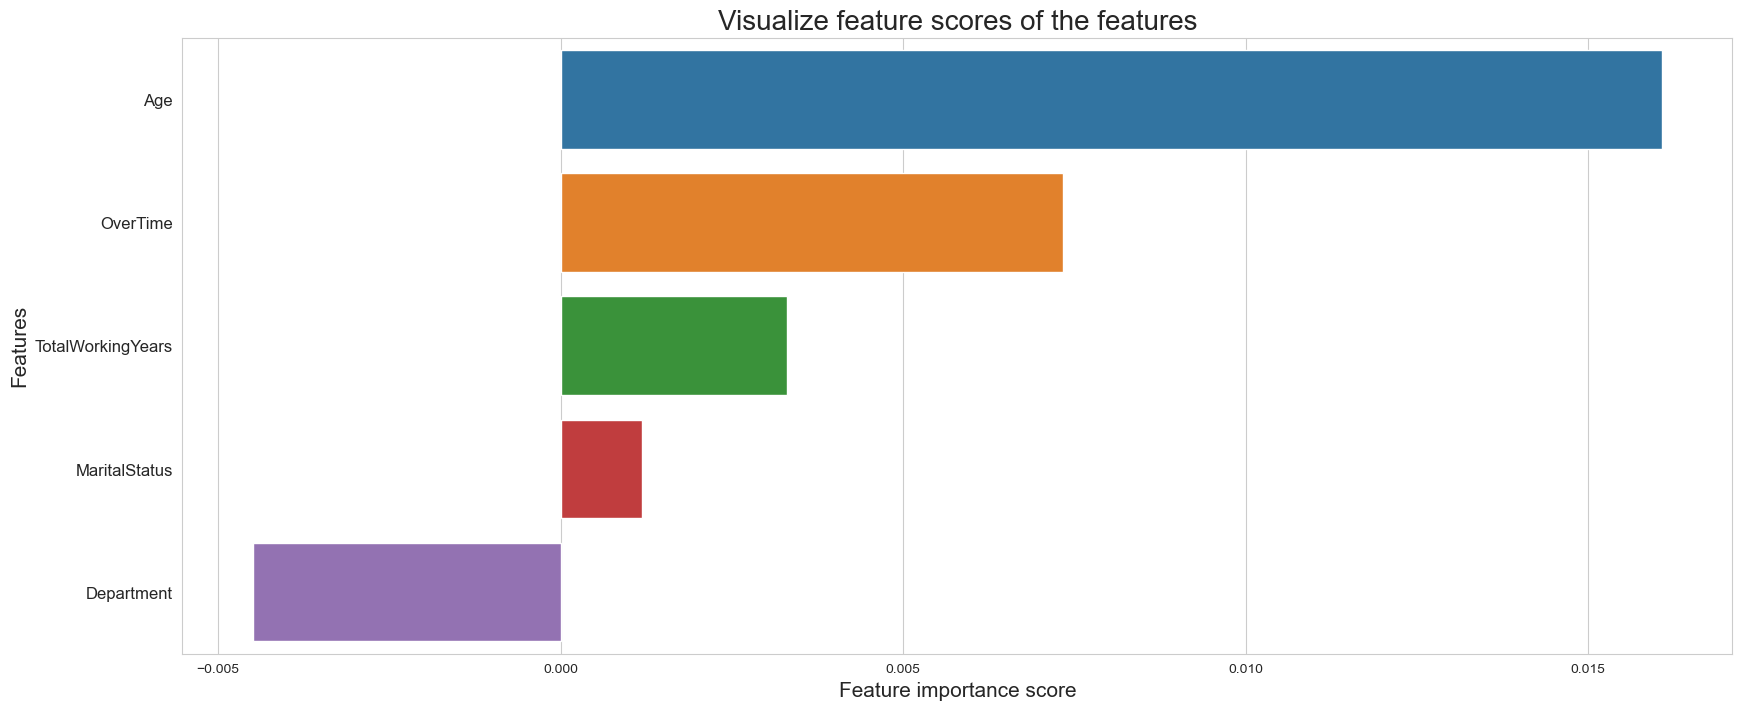

In [88]:
# Creating a seaborn bar plot

f, ax = plt.subplots(figsize=(20, 8))
ax = sns.barplot(x=importancia_features_sort.importancia, y=importancia_features_sort.index, data=importancia_features_sort)
ax.set_title("Visualize feature scores of the features",fontsize=20)
ax.set_yticklabels(importancia_features_sort.index, fontsize=12)
ax.set_xlabel("Feature importance score",fontsize=15)
ax.set_ylabel("Features",fontsize=15)
plt.show()

***
<a id="4"></a> <br>
## 4. Exportación con Shelve

<a id="41"></a> <br>
### 4.1. Exportación con Shelve

In [89]:
dtree = shelve.open('../Models Shelve/08.DecissionTree.db')

dtree['modelo'] = model
dtree["metricas"] = df_metricas

dtree.close()